In [366]:
from clan_tools.data_adapters.ClickHouseYTAdapter import ClickHouseYTAdapter
import pandas as pd
import numpy as np
import seaborn as sns
from io import BytesIO
from scipy.optimize import minimize
from tokens import token
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [367]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [368]:
chyt = ClickHouseYTAdapter(token = token)

Посмотрим на распределение максимальных MRR в Mass сегменте в диапазоне от 100 до 30К рублей в месяц. 
Максимальный MRR считается это максимальное недельное потребление без НДС (включая триалы), отмасштабированное до месячного (MRR = weekly_consumption*52/12)

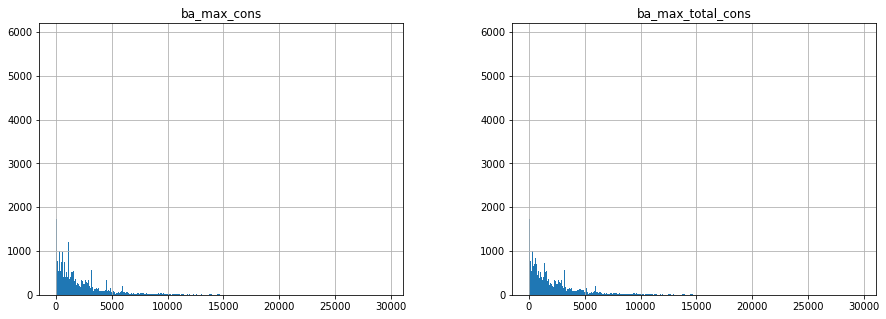

In [369]:
query0 = """
SELECT billing_account_id, max(paid_cons) as ba_max_cons, max(total_cons) as ba_max_total_cons,
multiIf(ba_max_cons<1000,'a.0-1K', 
            ba_max_cons<3000, 'b.1K-3K',
            ba_max_cons<10000, 'c.3K-10K',
            'd.10K and higher') as ba_max_cons_bucket
FROM (
SELECT DISTINCT
    billing_account_id,
    argMax(segment, event_time) as segment,
    argMin(toDate(first_ba_created_datetime), event_time) as ba_created_w,
    toMonday(toDate(event_time)) as w,
    sum(trial_consumption_vat + real_consumption_vat)*52/12 as paid_cons,
    sum(trial_consumption_vat + real_consumption_vat)*52/12 as total_cons
FROM
    "//home/cloud_analytics/cubes/acquisition_cube/cube"
WHERE 1=1
    and ba_usage_status != 'service'
    and event = 'day_use'
    and sku_lazy = 0
GROUP BY 
    billing_account_id, w
)
GROUP BY billing_account_id
HAVING argMax(segment, w) = 'Mass' and ba_max_cons < 30000 and ba_max_cons > 1
"""

data0 = pd.read_csv(BytesIO(chyt.execute_query(query0)), na_values='\\N', sep ='\t', names = ['billing_account_id', 
                                                                                              'ba_max_cons',
                                                                                              'ba_max_total_cons',
                                                                                              'ba_max_cons_bucket'])
data0.hist(bins=1000, figsize=(15,5))
plt.show()

Выделим группы по размеру потребления (так чтобы они были схожих размеров):

In [370]:
data0.groupby('ba_max_cons_bucket').count()

,billing_account_id,ba_max_cons,ba_max_total_cons
ba_max_cons_bucket,,,
a.0-1K,30487,30487,30487
b.1K-3K,22372,22372,22372
c.3K-10K,16567,16567,16567
d.10K and higher,2161,2161,2161


Теперь разобьем аккаунты по недельным когортам, по размеру максимального потребления, и посчитаем сколько аккаунтов превышали 50% своего максимального потребления в зависимости от номера недели их жизненного цикла
Рассматриваем тех, кто зарегался в 2019 году, не фрод, и физлицо

In [371]:
query = """
SELECT
    ba_m_cohort,
    ba_max_cons_bucket,
    w_n,
    uniqExactIf(billing_account_id, total_cons_pct_to_max>25) as ba_count_25,
    uniqExactIf(billing_account_id, total_cons_pct_to_max>50) as ba_count_50,
    uniqExactIf(billing_account_id, total_cons_pct_to_max>75) as ba_count_75
FROM (
SELECT
    billing_account_id,
    ba_m_cohort,
    ba_max_cons,
    ba_max_total_cons,
    multiIf(ba_max_cons<1000,'a.0-1K', 
            ba_max_cons<3000, 'b.1K-3K',
            ba_max_cons<10000, 'c.3K-10K',
            'd.10K and higher') as ba_max_cons_bucket,
    ba_created_w,
    w,
    dateDiff('week', ba_created_w, w) as w_n,
    total_cons,
    total_cons/ba_max_total_cons*100 as total_cons_pct_to_max
FROM (
SELECT DISTINCT
    billing_account_id,
    toMonday(argMax(toDate(first_ba_created_datetime), event_time)) as ba_created_w,
    toMonday(argMax(toDate(first_ba_created_datetime), event_time)) as ba_m_cohort,
    toMonday(toDate(event_time)) as w,
    sum(trial_consumption_vat + real_consumption_vat)*52/12 as paid_cons,
    sum(trial_consumption_vat + real_consumption_vat)*52/12 as total_cons
FROM
    "//home/cloud_analytics/cubes/acquisition_cube/cube"
WHERE 1=1
    and event = 'day_use'
    and sku_lazy = 0
    and w < toMonday(now())
GROUP BY 
    billing_account_id, w
) as a INNER JOIN (
SELECT 
    billing_account_id, 
    max(paid_cons) as ba_max_cons, 
    max(total_cons) as ba_max_total_cons
FROM (
SELECT DISTINCT
    billing_account_id,
    argMax(segment, event_time) as segment,
    argMax(ba_person_type, event_time) as ba_person_type,
    argMax(is_fraud, event_time) as is_fraud,
    argMin(toDate(first_ba_created_datetime), event_time) as ba_created_w,
    toMonday(toDate(event_time)) as w,
    sum(trial_consumption_vat + real_consumption_vat)*52/12 as paid_cons,
    sum(trial_consumption_vat + real_consumption_vat)*52/12 as total_cons
FROM
    "//home/cloud_analytics/cubes/acquisition_cube/cube"
WHERE 1=1
    and ba_usage_status != 'service'
    and event = 'day_use'
    and sku_lazy = 0
GROUP BY 
    billing_account_id, w
)
GROUP BY billing_account_id
HAVING 1=1 
    and argMax(segment, w) = 'Mass' 
    and ba_max_cons < 30000 
    and ba_max_cons > 100
    and argMax(ba_person_type, w) = 'individual'
) as b 
ON a.billing_account_id = b.billing_account_id
WHERE ba_max_cons>0
)
WHERE 1=1 
    and w_n >=0
    and toStartOfYear(ba_m_cohort) = '2019-01-01' 
    --and SUBSTRING(ba_max_cons_bucket,1,1) in ('a', 'b','c' )
GROUP BY 
ba_m_cohort, ba_max_cons_bucket, w_n
"""

data = pd.read_csv(BytesIO(chyt.execute_query(query)), na_values='\\N', sep ='\t', names = ['ba_m_cohort',
                                                                                            'ba_max_cons_bucket',
                                                                                            'w_n',
                                                                                            'ba_count_25',
                                                                                            'ba_count_50',
                                                                                            'ba_count_75'])
data.head()

,ba_m_cohort,ba_max_cons_bucket,w_n,ba_count_25,ba_count_50,ba_count_75
0,2019-02-11,d.10K and higher,1,23,20,19
1,2019-05-20,b.1K-3K,35,7,7,6
2,2019-10-07,a.0-1K,13,12,8,8
3,2019-10-14,c.3K-10K,10,4,4,4
4,2019-07-08,b.1K-3K,26,7,5,3


Перейдем к процентам, отшкалировав на максимум

In [372]:
data2 = pd.merge(data, 
         data.groupby([ 'ba_m_cohort', 
                        'ba_max_cons_bucket'], as_index=False).agg({'ba_count_50':'max'}).rename({'ba_count_50':'ba_count_50_max'}, axis=1),
         on = ['ba_m_cohort', 'ba_max_cons_bucket'])
data2['ba_count_pct'] = data2['ba_count_50'] / data2['ba_count_50_max']
data2['ba_m_cohort_max_cons_bucket'] = data2['ba_m_cohort'] + ' ' + data2['ba_max_cons_bucket']
data2.sort_values(['ba_m_cohort', 'ba_max_cons_bucket'], inplace=True)
data2.head()

,ba_m_cohort,ba_max_cons_bucket,w_n,ba_count_25,ba_count_50,ba_count_75,ba_count_50_max,ba_count_pct,ba_m_cohort_max_cons_bucket
3199,2019-01-07,a.0-1K,53,6,4,3,130,0.030769,2019-01-07 a.0-1K
3200,2019-01-07,a.0-1K,27,10,10,7,130,0.076923,2019-01-07 a.0-1K
3201,2019-01-07,a.0-1K,42,8,7,5,130,0.053846,2019-01-07 a.0-1K
3202,2019-01-07,a.0-1K,4,64,60,52,130,0.461538,2019-01-07 a.0-1K
3203,2019-01-07,a.0-1K,11,11,10,8,130,0.076923,2019-01-07 a.0-1K


Посмотрим на кол-во юзеров в когортах

In [373]:
data2_pivot = pd.pivot_table(data=data2, index='ba_m_cohort', columns='ba_max_cons_bucket', values='ba_count_50_max', fill_value=0).reset_index()

cm = sns.light_palette('blue', as_cmap=True)

s = data2_pivot.style.background_gradient(cmap=cm,low=0, high=1, axis=0)
s

ba_max_cons_bucket,ba_m_cohort,a.0-1K,b.1K-3K,c.3K-10K,d.10K and higher
0,2019-01-07,130,119,88,11
1,2019-01-14,97,122,74,8
2,2019-01-21,115,102,75,13
3,2019-01-28,123,122,94,8
4,2019-02-04,74,108,64,10
5,2019-02-11,103,196,154,20
6,2019-02-18,91,62,125,17
7,2019-02-25,78,174,228,11
8,2019-03-04,60,107,218,16
9,2019-03-11,99,84,210,11


Видно, что приток новых пользователей сильно снизился в сентябре 2019 из-за ввода новой триальной политики, особенно в группе "с" (MRR 3-10K), но и конверсия сильно повысилась (см. графики в процентах). 

a


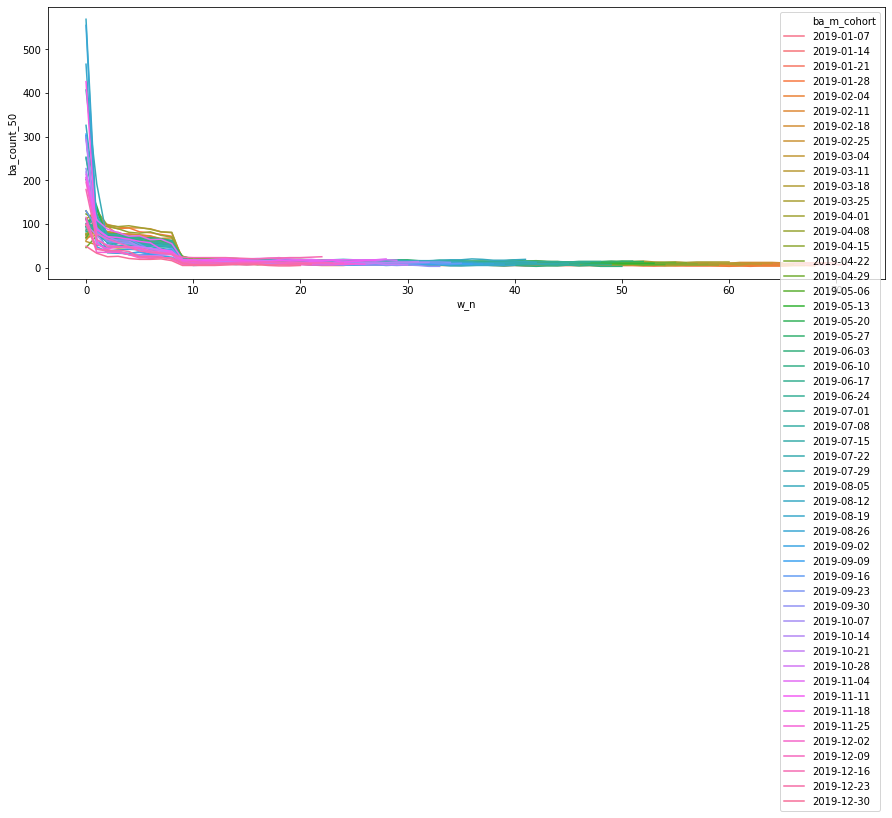

b


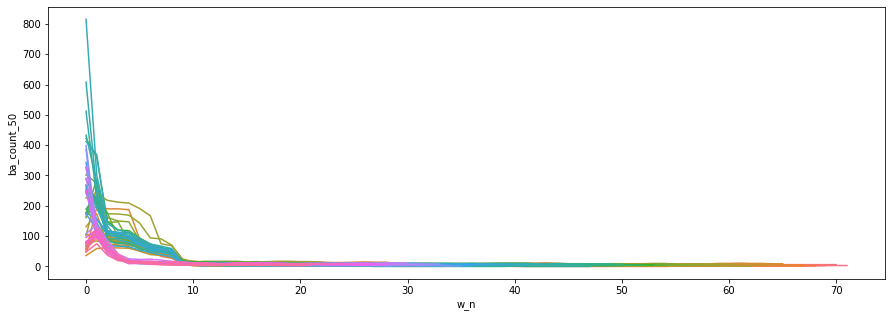

c


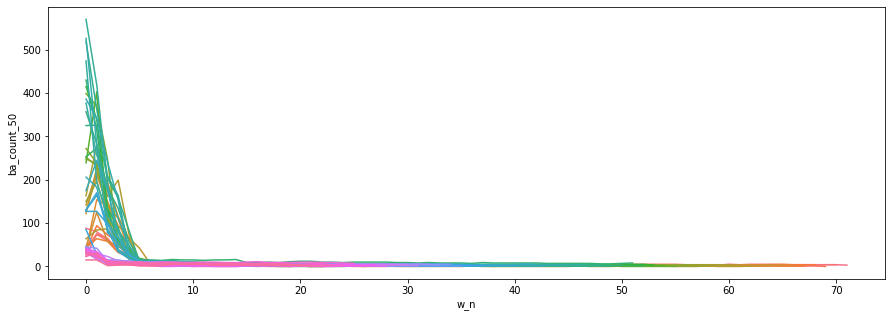

In [374]:
for z in ['a','b','c']:
    print(z)
    plt.figure(figsize=(15,5))
    if z == 'a': 
        sns.lineplot(data=data2[(data2['w_n']>-10) & (data2['ba_max_cons_bucket'].apply(lambda x: x[0]) == z)], x='w_n', y='ba_count_50', hue='ba_m_cohort', )
    else:
        sns.lineplot(legend=False,data=data2[(data2['w_n']>-10) & (data2['ba_max_cons_bucket'].apply(lambda x: x[0]) == z)], x='w_n', y='ba_count_50', hue='ba_m_cohort', )
    plt.show()

a


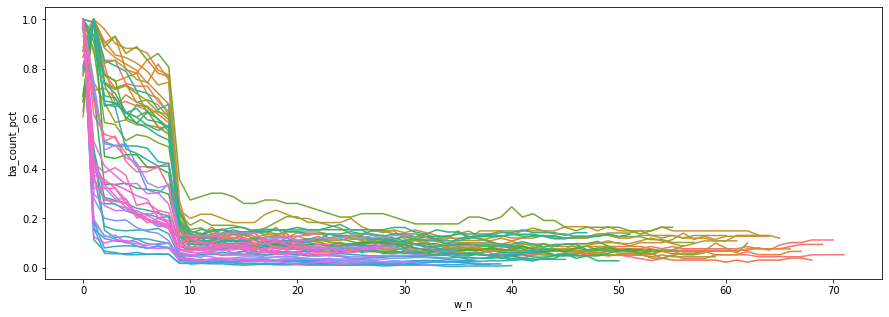

b


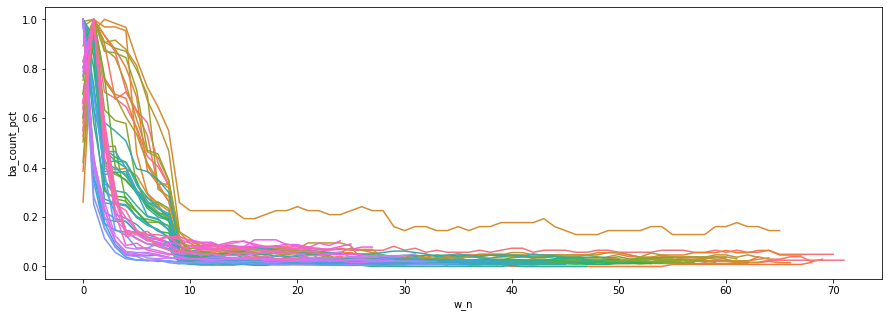

c


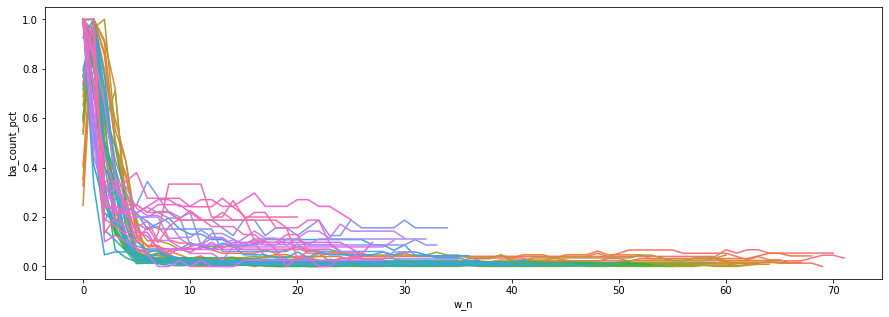

In [375]:
for z in ['a','b','c']:
    print(z)
    plt.figure(figsize=(15,5))
    sns.lineplot(legend=False,data=data2[(data2['w_n']>-10) & (data2['ba_max_cons_bucket'].apply(lambda x: x[0]) == z)], x='w_n', y='ba_count_pct', hue='ba_m_cohort', )
    plt.show()

Лучше всего для калибровки retention подходит группа "b" - тут меньше всего шума

## Калибровка retention curve
Кривую retention curve можно сравнить с функцией распределения вероятности, только отраженной по вертикали - если функция плотности монотонно возрастает, то retention curve монотонно убывает. Также схож и смысл если F(x) = P(X<x), то и RC(w_n) = P(W>w_n)

Также можно получить аналог плотности вероятности взяв ее производную (в дискретном случае - посчитать first-Difference). Действительно, если на 2й неделе сервисом пользовались 80% когорты, а на 3й 70%, то можно сказать, что вероятность что пользователь проживет ровно три недели равна 10% 

Так как мы хотим посчитать средний срок жизни, то мы будем считать сумму произведений w_n * -RC'(w_n)
Если мы возьмем RC = 1/x, то такая сумма у нас никогда сходится не будет - ряд x*1/x^2 = 1/x расходится и среднее время жизни будет стремиться к бесконечности. Поэтому для расчетов я взял функцию 1/x^2

In [376]:
def hyperbola(params=[1,0,1], x=1):
    a, b, c = params
    return a + b/(c+x**2)

def errf(params, data):
    return np.sum([(d[1] - hyperbola(params, d[0]))**2 for d in data])

Строим кривую на 250 недель ~ 5 лет

b
[ 0.          9.44794394 11.68038921]
0.9999999999999999


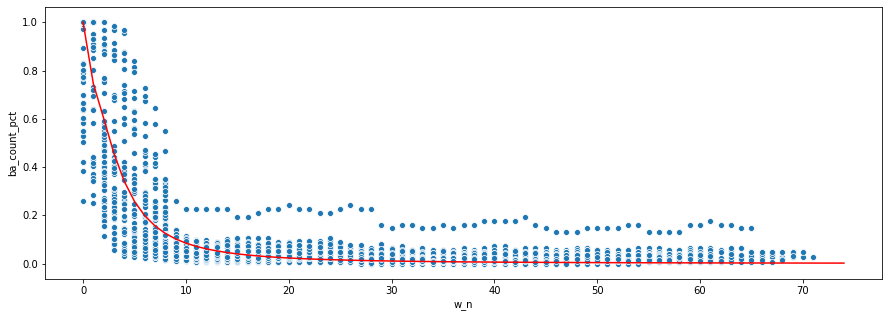

mean = 3.9000857519097853
median = 2.68


In [377]:
for z in ['b']:
    print(z)
    data_train = data2[(data2['ba_max_cons_bucket'].apply(lambda x: x[0]) == z)][['w_n', 'ba_count_pct']]
    res = minimize(lambda p: errf(p, data_train.values),
                   [1,1,1], 
                   method='SLSQP',
                   bounds=((0,0),(0,1000),(0,1000)))
    print(res.x)
    curve_ = [1] + [hyperbola(params = res.x, x=x) for x in range(0,250)][1:] + [0]
    
    curve_diff = [j-i for i, j in zip(curve_[1:], curve_[:-1])]
    print(np.sum(curve_diff))
    plt.figure(figsize=(15,5))
    sns.scatterplot(data=data_train,
                    x='w_n',
                    y='ba_count_pct')
    plt.plot(curve_[:75], color='red')
    plt.show()
    print ('mean = ' + str(np.sum([(x)*y for x, y in enumerate(curve_diff)])))
    for i in range(100):
        if hyperbola(res.x, 3.27-i/100) >0.5:
            print ('median = ' + str(3.27-i/100))
            break

Получили результат в 3 недели (и приблизительно такое же медианное значение)

Теперь попробуем оставить только тех, кто конвертнулся в платное ("прожил" больше 10 недель). Возьмем часть RC, где w_n > 10, отмасштабируем его и оценим средний срок жизни тех, кто конвертнулся:

b
[0.02242332 7.68745444 9.57203903]
1.0


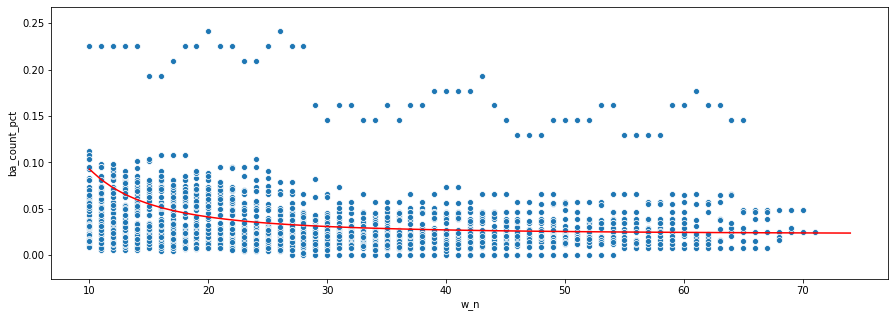

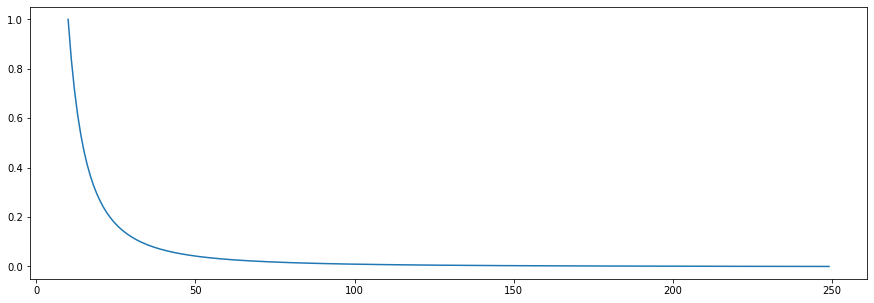

mean = 19.296556324289654
median = 14


In [378]:
for z in ['b']:
    print(z)
    data_train = data2[(data2['ba_max_cons_bucket'].apply(lambda x: x[0]) == z)][['w_n', 'ba_count_pct']]
    res = minimize(lambda p: errf(p, data_train.values),
                   [1,1,1], 
                   method='SLSQP',
                   bounds=((0,1000),(0,1000),(0,1000)))
    print(res.x)
    curve_ = [1] + [hyperbola(params = res.x, x=x) for x in range(0,250)][1:] 
    curve = [(x-curve_[-1])/(curve_[10]-curve_[-1]) for x in curve_[10:]]
    curve_diff = [j-i for i, j in zip(curve[1:], curve[:-1])]
    print(np.sum(curve_diff))
    plt.figure(figsize=(15,5))
    sns.scatterplot(data=data_train[data_train['w_n'] >= 10],
                    x='w_n',
                    y='ba_count_pct')
    plt.plot(range(10,75), curve_[10:75], color='red')
    plt.show()
    plt.figure(figsize=(15,5))
    plt.plot(range(10,250), curve)
    plt.show()
    print ('mean = ' + str(10+np.sum([(x)*y for x, y in enumerate(curve_diff)])))
    for i, j in enumerate(curve):
        if j < 0.5:
            print ('median = ' + str(10+i-1))
            break

Попробуем симуляции Монте-Карло, чтобы оценить разброс нашей оценки.
Обучим нашу модель 100 раз на случайной трети нашей выборки: 

  0%|          | 0/100 [00:00<?, ?it/s]/home/artkaz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
  1%|          | 1/100 [00:00<01:04,  1.54it/s]/home/artkaz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 100/100 [01:07<00:00,  1.47it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e368f0e10>]],
      dtype=object)

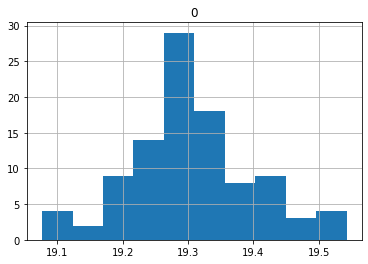

In [379]:
from tqdm import tqdm
curves = []
lifetime = []
data_train = data2[(data2['ba_max_cons_bucket'].apply(lambda x: x[0]) == 'b')][['w_n', 'ba_count_pct']]
for i in tqdm(range(100)):
    data_train_sample = data_train.sample(frac=0.3)
    res = minimize(lambda p: errf(p, data_train_sample.values),
                   [1,1,1], 
                   method='SLSQP',
                   bounds=((0,1000),(0,1000),(0,1000)))
    curve_ = [1] + [hyperbola(params = res.x, x=x) for x in range(0,250)][1:] 
    curve = [(x-curve_[-1])/(curve_[10]-curve_[-1]) for x in curve_[10:]]
    curve_diff = [j-i for i, j in zip(curve[1:], curve[:-1])]
    curves.append(res.x)
    lifetime.append(10+np.sum([(x)*y for x, y in enumerate(curve_diff)]))

pd.DataFrame(lifetime).hist()

В целом разброс не очень большой. Еще хочется посмотреть, как влияют на результаты единственный гиперпараметр нашей модели - степень гиперболы

In [380]:
def hyperbola2(params=[1,0,1], x=1, power=2):
    a, b, c = params
    return a + b/(c+x**power)

def errf2(params, data, power):
    return np.sum([(d[1] - hyperbola2(params, d[0], power))**2 for d in data])

  0%|          | 0/30 [00:00<?, ?it/s]/home/artkaz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/artkaz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 30/30 [00:59<00:00,  1.99s/it]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e3d12da90>]],
      dtype=object)

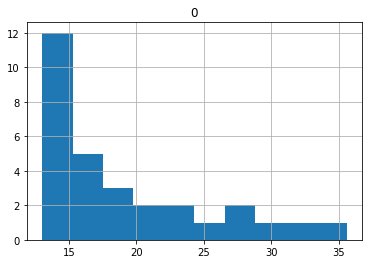

In [381]:
lifetime = []
data_train = data2[(data2['ba_max_cons_bucket'].apply(lambda x: x[0]) == 'b')][['w_n', 'ba_count_pct']]
for i in tqdm(range(30)):
    res = minimize(lambda p: errf2(p, data_train.values, 1+i/10),
                   [1,1,1], 
                   method='SLSQP',
                   bounds=((0,1000),(0,1000),(0,1000)))
    curve_ = [1] + [hyperbola2(params = res.x, x=x, power=1+i/10) for x in range(0,250)][1:] 
    curve = [(x-curve_[-1])/(curve_[10]-curve_[-1]) for x in curve_[10:]]
    curve_diff = [j-i for i, j in zip(curve[1:], curve[:-1])]
    curves.append(res.x)
    lifetime.append(10+np.sum([(x)*y for x, y in enumerate(curve_diff)]))

pd.DataFrame(lifetime).hist()

In [382]:
np.mean(lifetime)

19.047065329007335

In [383]:
lifetime

[35.57334074689905,
 32.93390233305135,
 30.578852655158197,
 28.49009348820099,
 26.6455184334851,
 24.988067105205285,
 23.520006931615466,
 22.241302534508183,
 21.125806718561982,
 20.1507424401751,
 19.296556324289654,
 18.545998439468523,
 17.88474097655,
 17.300381269543735,
 16.78214314604734,
 16.321110596769955,
 15.909369393766735,
 15.540617149014228,
 15.2090052431843,
 14.909761298649169,
 14.638827716750452,
 14.392689688922967,
 14.168344801769175,
 13.963192019375253,
 13.775035376694069,
 13.601945224142646,
 13.442250587830795,
 13.294555323123546,
 13.157568480301215,
 13.03023342716563]

Видим, что чем больше степень, тем меньше срок жизни, что согласуется с интуицией. Ну и оценка в 20 недель - довольно устойчивая.